# Modeling XGBoost

XGBoost is selected because it's one of the most powerful and widely-used algorithms for structured tabular data, especially in classification problems like loan default prediction. It builds an ensemble of decision trees using gradient boosting, which allows it to capture complex non-linear relationships and feature interactions that simpler models might miss.

### Import data

In [3]:
#Import libraries
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score,classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import joblib

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Read data that was exported from previous session
df = pd.read_csv("../processed/loan_data_baseline_ready.csv")
df.head()

,loan_amnt,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,loan_default
0,4000.0,13.08,134.93,1,10.0,MORTGAGE,48000.0,Source Verified,Current,home_improvement,20.25,0
1,24000.0,9.16,500.07,1,6.0,RENT,57000.0,Source Verified,Current,credit_card,25.33,0
2,5000.0,10.49,162.49,1,10.0,MORTGAGE,55000.0,Not Verified,Fully Paid,credit_card,7.22,0
3,24000.0,11.05,522.42,1,10.0,MORTGAGE,43500.0,Not Verified,Current,debt_consolidation,24.55,0
4,14000.0,13.59,322.79,2,10.0,MORTGAGE,48000.0,Source Verified,Fully Paid,debt_consolidation,24.30,0


### Feature selection and Data Splitting

In [4]:
# 1. Select features and target
X = df.drop(columns=["loan_status", "loan_default"])
y = df["loan_default"]

# 3. Encode categorical features
from sklearn.preprocessing import LabelEncoder

categorical_cols = X.select_dtypes(include="object").columns
X_encoded = X.copy()

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])



In [5]:
# 4. Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=42
)

# Print data shapes
print("Training Data Shape:", X_train.shape)
print("Test Data Shape:", X_test.shape)

Training Data Shape: (80000, 10)
Test Data Shape: (20000, 10)


### Basic XGBoost Model training

In [6]:
# Class imbalance ratio
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Basic XGBoost model
model = XGBClassifier(
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

# Train
model.fit(X_train, y_train)

# Predict & evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.69      0.79     17413
           1       0.23      0.62      0.33      2587

    accuracy                           0.68     20000
   macro avg       0.58      0.65      0.56     20000
weighted avg       0.83      0.68      0.73     20000

ROC-AUC Score: 0.715140248508289


The model shows strong potential by capturing a majority of actual defaults, and already better than baseline model. However, its low precision indicates many false positives, suggesting that hyperparameter tuning is needed to improve its balance and overall performance

### XGBoost with hyperparameter tuning

In [8]:
# Define base model with class imbalance handling
xgb = XGBClassifier(
    eval_metric="logloss",
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=42
)
# Adding hyperparameter grid
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1],
    "colsample_bytree": [0.8, 1]
}

search = RandomizedSearchCV(xgb, param_distributions=param_grid,
                            scoring="roc_auc", cv=3, n_iter=10,
                            verbose=1, random_state=42, n_jobs=-1)

search.fit(X_train, y_train)
best_model = search.best_estimator_
# Save the trained model to use in the real-time app
joblib.dump(best_model, "../../app/model_baseline.pkl")

Fitting 3 folds for each of 10 candidates, totalling 30 fits


['../../app/model_baseline.pkl']

In [9]:
# Calculate performance metrics
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.64      0.76     17413
           1       0.22      0.70      0.34      2587

    accuracy                           0.65     20000
   macro avg       0.58      0.67      0.55     20000
weighted avg       0.84      0.65      0.71     20000

ROC-AUC Score: 0.7320826242011449


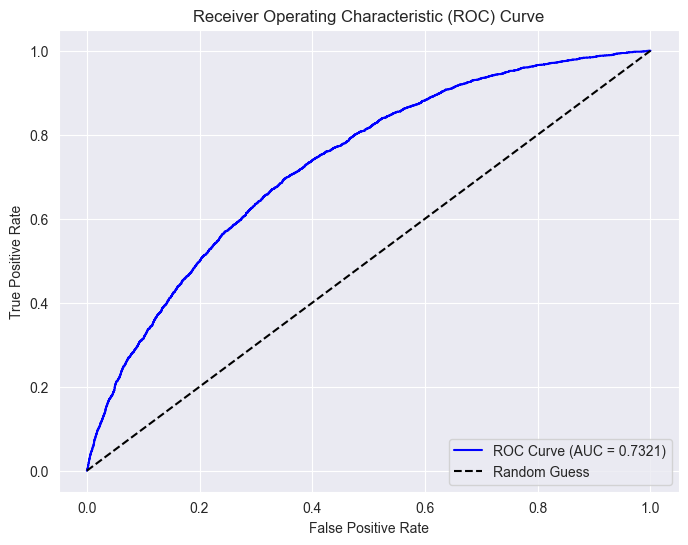

Stratified CV ROC-AUC Scores: [0.73404823 0.73585018 0.73160048 0.72797292 0.71766052]
Mean Stratified CV ROC-AUC: 0.7294


In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring="roc_auc")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"Stratified CV ROC-AUC Scores: {cv_scores}")
print(f"Mean Stratified CV ROC-AUC: {np.mean(cv_scores):.4f}")


###  Comparison Summary

Compared to the baseline Logistic Regression model, the tuned XGBoost model achieved a higher ROC-AUC (0.732 vs. 0.703) and improved recall (70% vs. 65.6%), making it more effective at identifying defaulting borrowers. Precision remains low in both models, reflecting the challenge of false positives. However, XGBoost shows stronger overall performance and learning capacity. Further gains can be achieved through feature selection and engineering to help reduce noise and improve precision.


